<ipython-input-6-cb0759fd4de6>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('apple_stock_data_2004_2024.csv', parse_dates=['Date'], index_col='Date')


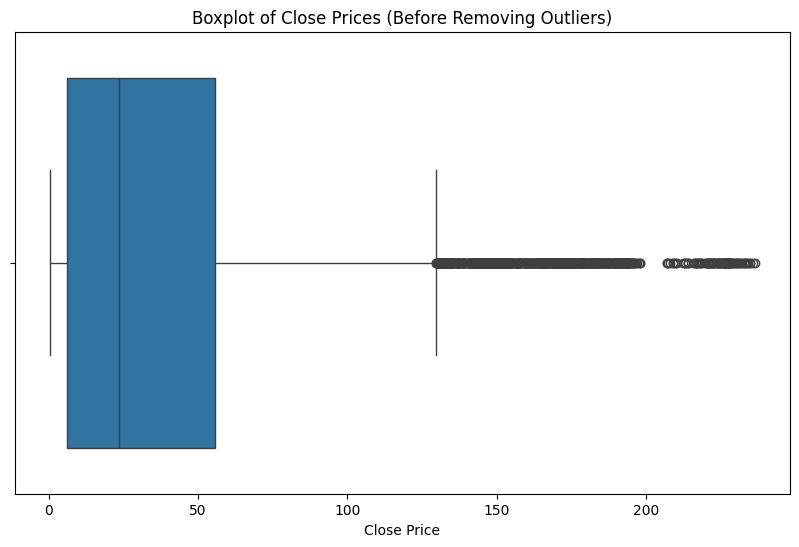

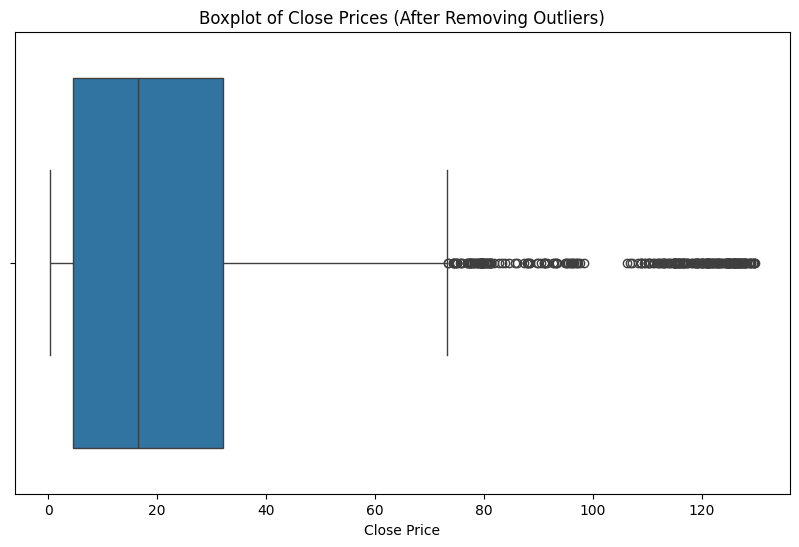

Number of outliers removed: 911


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv('apple_stock_data_2004_2024.csv', parse_dates=['Date'], index_col='Date')

# Convert 'Close' column to numeric, handling errors
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

# Visualize the data before removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['Close'])
plt.title('Boxplot of Close Prices (Before Removing Outliers)')
plt.xlabel('Close Price')
plt.show()

# Calculate the IQR for the 'Close' column
Q1 = data['Close'].quantile(0.25)
Q3 = data['Close'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = data[(data['Close'] < lower_bound) | (data['Close'] > upper_bound)]

# Remove outliers
data_cleaned = data[(data['Close'] >= lower_bound) & (data['Close'] <= upper_bound)]

# Visualize the data after removing outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_cleaned['Close'])
plt.title('Boxplot of Close Prices (After Removing Outliers)')
plt.xlabel('Close Price')
plt.show()

# Print the number of outliers removed
print(f"Number of outliers removed: {len(outliers)}")

In [7]:
#Save the cleaned dataset
data_cleaned.to_csv('App_hist_cleaned_dataset.csv', index=False)

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the dataset
df = pd.read_csv('App_hist_cleaned_dataset.csv')

In [24]:
# Data Cleaning
# Drop unnecessary columns
df = df[['Close']]

# Check for missing values
df.isnull().sum()

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [26]:
# Prepare the dataset for LSTM
def create_dataset(data, time_step=28):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 28
X, Y = create_dataset(scaled_data, time_step)

In [27]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [28]:
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

In [54]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [49]:
model.fit(X_train, Y_train, batch_size=32, epochs=10)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 6.3588e-06
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.9901e-06
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.9692e-06
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 6.1392e-06
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.0963e-06
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 4.8695e-06
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 5.1829e-06
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 5.7232e-06
Epoch 9/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 5.3291e-06
Epoch 10/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.0551e-06


In [50]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [51]:
train_predict = scaler.inverse_transform(train_predict)
Y_train_inv = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test_inv = scaler.inverse_transform([Y_test])

In [52]:
mse = mean_squared_error(Y_test_inv[0], test_predict[:, 0])
mae = mean_absolute_error(Y_test_inv[0], test_predict[:, 0])
print(mse)
print(mae)

21.256631894258938
2.771098506988317


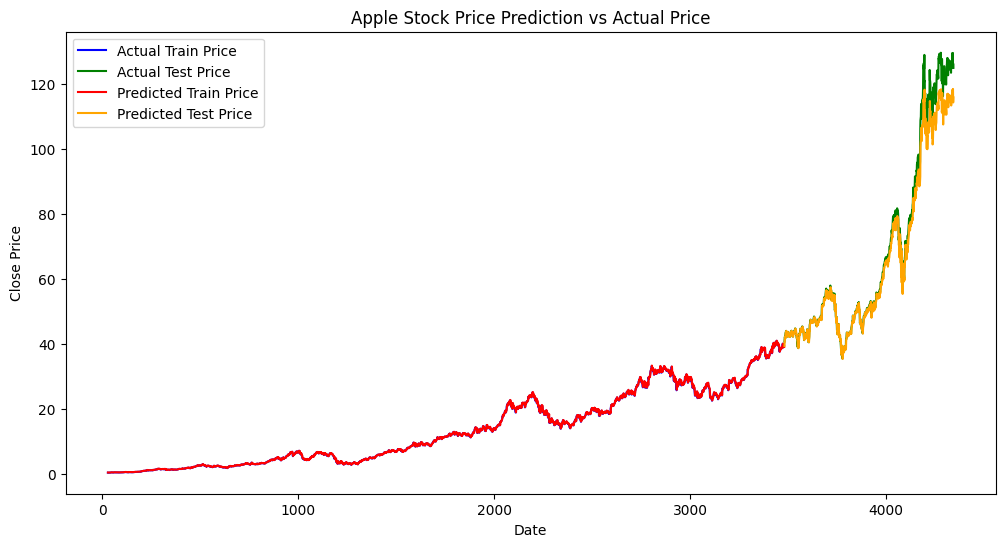

In [53]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[time_step:train_size + time_step], Y_train_inv[0], label='Actual Train Price', color='blue')
plt.plot(df.index[train_size + time_step + 1:len(df)], Y_test_inv[0], label='Actual Test Price', color='green')
plt.plot(df.index[time_step:train_size + time_step], train_predict[:, 0], label='Predicted Train Price', color='red')
plt.plot(df.index[train_size + time_step + 1:len(df)], test_predict[:, 0], label='Predicted Test Price', color='orange')
plt.title('Apple Stock Price Prediction vs Actual Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()